In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import utils.add_features as af
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from copy import deepcopy 

2024-03-10 11:57:31.168078: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-10 11:57:31.201026: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 11:57:31.201054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 11:57:31.202085: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-10 11:57:31.207565: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-10 11:57:31.208381: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
SPLIT_DATE           = '2022-05-29 00:00:00'
INTERPOLATION_METHOD = 'linear'
INTERPOLATION_ORDER  = 3
RESAMPLE_FREQ        = '5min'

#MODEL PARAMETERS
PATIENCE             = 10
EPOCHS               = 100
WINDOW_SIZE          = 50 #keep in mind that each data point is 5 minutes apart
BATCH_SIZE           = 32 
TIMESTEPS_AHEAD      = 36 #keep in mind that each data point is 5 minutes apart
SHUFFLE_BUFFER_SIZE  = 1000


In [3]:
DATA_PATHS = ['./datasets/ambient_measurements/2022/lux.csv',
              './datasets/ambient_measurements/2022/temp.csv',
              './datasets/ambient_measurements/2022/hum.csv',
              './datasets/ambient_measurements/2022/pressure.csv',]

datasets = [pd.read_csv(path, index_col=0, parse_dates=True) for path in DATA_PATHS]
datasets = [af.interpolate_and_resample(df) for df in datasets]

In [4]:
full_dataset = af.encode_date(af.join_data(datasets))
full_dataset.shape

(4855, 8)

In [5]:
full_dataset.head()

,lux_level,temp_level,hum_level,pressure_level,hour_sin,hour_cos,day_of_year_sin,day_of_year_cos
time,,,,,,,,
2022-05-09 21:20:00,420.210,21.143333,50.286667,748.080000,-12.470015,20.506066,290.606745,-220.845465
2022-05-09 21:30:00,3.125,21.065000,50.390000,748.015000,-12.470015,20.506066,290.606745,-220.845465
2022-05-09 21:40:00,2.920,20.965000,50.470000,747.856667,-12.470015,20.506066,290.606745,-220.845465
2022-05-09 21:50:00,2.920,20.965000,50.570000,747.880000,-12.470015,20.506066,290.606745,-220.845465
2022-05-09 22:00:00,2.920,21.050000,50.570000,748.050000,-6.475123,23.110015,290.606745,-220.845465


# split the data and generate the windowed datasets

In [6]:
# Split the data into training and testing sets
train = deepcopy(full_dataset[:SPLIT_DATE])
test = deepcopy(full_dataset[SPLIT_DATE:])

In [7]:
def windowed_dataset(fulldata: pd.DataFrame,
                     window_size: int,
                     batch_size: int,
                     shuffle_buffer: int,
                     timesteps_ahead: int = 12, 
                     shuffle: bool = True) -> tf.data.Dataset:

    """
    Generates dataset windows

    Args:
      fulldata (pd.DataFrame) - contains the values of the time series
      window_size (int)       - the number of time steps to average
      batch_size (int)        - the batch size
      timestep_ahead (int)    - the number of time steps to predict
      shuffle_buffer(int)     - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Convert the series to a numpy array
    series = fulldata.to_numpy()

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + timesteps_ahead, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + timesteps_ahead))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-timesteps_ahead], window[-timesteps_ahead:, 1]))

    # Shuffle the windows
    if shuffle:
        dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset


In [8]:
train_dataset = windowed_dataset(train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, TIMESTEPS_AHEAD)
test_dataset = windowed_dataset(test, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, TIMESTEPS_AHEAD)

# Print properties of a single batch
for windows in train_dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')
  #print(f'first element: {windows[1]}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 50, 8)
shape of second element: (32, 36)


2024-03-10 11:57:33.156405: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-10 11:57:33.156894: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# first model trial 

In [32]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[WINDOW_SIZE, 8]),

    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(WINDOW_SIZE, return_sequences=True, activation="relu")),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(WINDOW_SIZE, return_sequences=True, activation="relu")),

    tf.keras.layers.Conv1D(filters=30, kernel_size=5, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.Conv1D(filters=30, kernel_size=5, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(TIMESTEPS_AHEAD),
])

model1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_14 (Bidirect  (None, 50, 100)           18000     
 ional)                                                          
                                                                 
 bidirectional_15 (Bidirect  (None, 50, 100)           45600     
 ional)                                                          
                                                                 
 conv1d_7 (Conv1D)           (None, 50, 30)            15030     
                                                                 
 conv1d_8 (Conv1D)           (None, 50, 30)            4530      
                                                                 
 flatten_6 (Flatten)         (None, 1500)              0         
                                                                 
 dense_6 (Dense)             (None, 36)               

In [33]:
loss = tf.losses.Huber() #tf.losses.MeanSquaredError()
model1.compile(loss = loss,
               optimizer = "adam",
               metrics   = ["mae", "mse"])

#patience callback of 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, mode='min')

# Train the model and save the history
history = model1.fit(train_dataset,
                     epochs=EPOCHS,
                     validation_data=test_dataset,
                     callbacks=[early_stopping])

Epoch 1/100
84/84 [==============================] - 6s 38ms/step - loss: 1.7926 - mae: 2.2143 - mse: 26.8474 - val_loss: 0.9377 - val_mae: 1.3481 - val_mse: 3.2350
Epoch 2/100
84/84 [==============================] - 3s 31ms/step - loss: 0.4033 - mae: 0.7649 - mse: 0.9921 - val_loss: 0.5276 - val_mae: 0.9073 - val_mse: 1.4532
Epoch 3/100
84/84 [==============================] - 3s 32ms/step - loss: 0.3464 - mae: 0.7012 - mse: 0.8084 - val_loss: 0.5413 - val_mae: 0.9286 - val_mse: 1.3999
Epoch 4/100
84/84 [==============================] - 3s 31ms/step - loss: 0.2555 - mae: 0.5805 - mse: 0.5788 - val_loss: 0.5219 - val_mae: 0.9167 - val_mse: 1.2804
Epoch 5/100
84/84 [==============================] - 3s 31ms/step - loss: 0.2677 - mae: 0.5995 - mse: 0.6021 - val_loss: 0.4931 - val_mae: 0.8867 - val_mse: 1.1645
Epoch 6/100
84/84 [==============================] - 3s 32ms/step - loss: 0.2765 - mae: 0.6109 - mse: 0.6227 - val_loss: 0.3883 - val_mae: 0.7462 - val_mse: 0.9346
Epoch 7/100
84/

In [34]:
# Plot the loss and the MAE
fig = go.Figure()
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['loss'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_loss'], mode='lines', name='Test'))
fig.update_layout(title='Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

In [35]:
def plot_random_predictions(model_baseline,
                            test_dataset,
                            N: int = 12,
                            COLS: int = 4) -> None:
    """
    Plots N random predictions from the model_baseline compared to expected values from the test_dataset.
    
    Parameters:
    - model_baseline: The model used for making predictions. It must have a .predict() method.
    - test_dataset: The dataset to test the model on, expected to yield tuples of (features, labels).
    - N: The number of random predictions to plot. Default is 12.
    - COLS: The number of columns in the subplot grid. Default is 4.
    
    Returns:
    None. Displays a matplotlib figure with the plots.
    """
    # Make predictions on the test dataset
    baseline_preds = model_baseline.predict(test_dataset)
    
    # Concatenate all expected labels from the test dataset
    expected = np.concatenate([y for x, y in test_dataset], axis=0)
    print(f'Expected shape: {expected.shape}')
    
    # Randomly select N predictions for plotting
    samples = np.random.randint(0, len(baseline_preds), N)
    
    # Create subplots
    _, subplots = plt.subplots(N//COLS, COLS, figsize=(15, 10))
    subplots = subplots.ravel()
    
    # Plot each selected sample's expected vs. predicted values
    for i, sample in enumerate(samples):
        
        xrange = np.arange(len(expected[sample]))
        # concatenate the inputs and expected values, but plot the 
        # inputs in a different color than the expected values
        subplots[i].plot(xrange, expected[sample], label='Expected', color='blue')
        subplots[i].plot(xrange, list(baseline_preds[sample]), label='Predicted', color='red')
        subplots[i].legend()
        subplots[i].set_title(f'Prediction {sample}')
        
    plt.tight_layout()
    plt.show()

64/64 [==============================] - 1s 7ms/step
Expected shape: (2018, 36)


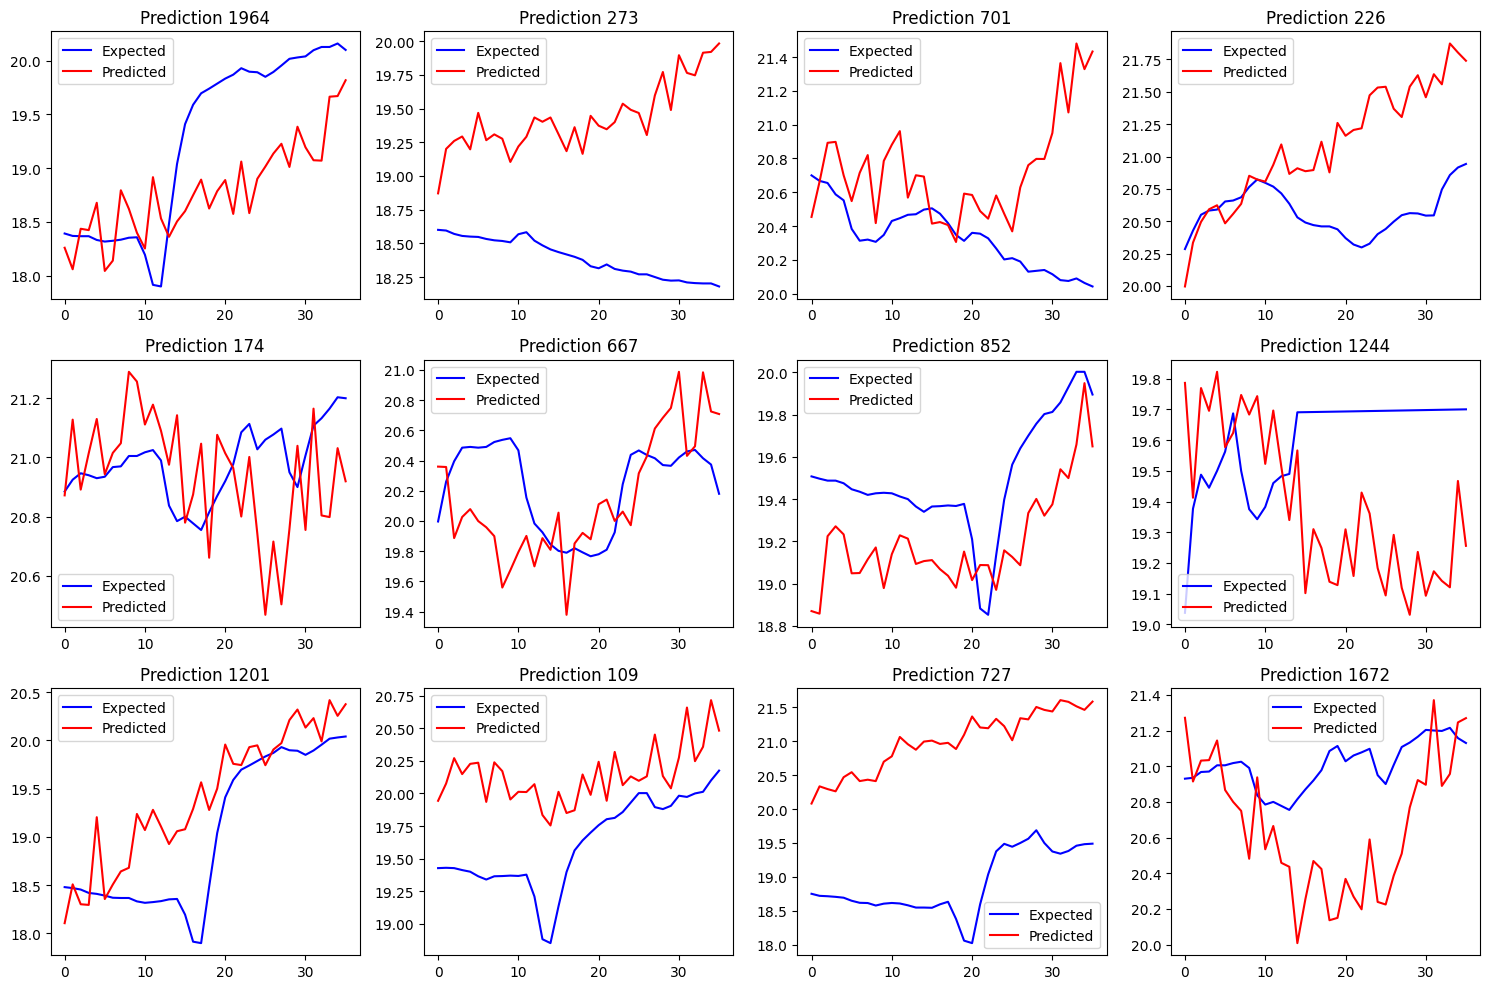

In [38]:
plot_random_predictions(model1, test_dataset, N=12, COLS=4)